In [16]:
import pandas as pd
with open('/content/drive/MyDrive/nlp/proj/nngen/data/cleaned.train.diff', 'r') as file:
  diff_data = file.read().splitlines()

with open('/content/drive/MyDrive/nlp/proj/nngen/data/cleaned.train.msg', 'r') as file:
  msg_data = file.read().splitlines()

#lists to df to perform EDA
diffs = pd.DataFrame(diff_data, columns=['diff'])
msgs = pd.DataFrame(msg_data, columns=['message'])

#merging into 1
df = pd.concat([diffs, msgs], axis=1)

print(df.head())

                                                diff  \
0  new file mode 100755 <nl> index 0000000 . . d1...   
1  mmm a / telecomm / java / android / telecomm /...   
2  similarity index 100 % <nl> rename from exampl...   
3  mmm a / modules / apps / foundation / microsof...   
4  mmm a / lib / nokogiri / version . rb <nl> ppp...   

                                             message  
0                               Added intro image .   
1  Fix WTF when creating a lazily initialized con...  
2                                    renamed test .   
3  ignore microsoft - translator 1 . 0 . 0 prep n...  
4                                bumping up version   


In [2]:
!pip install pandas matplotlib seaborn

In [17]:
print(df.shape)

#no missingn value which is a good thing
print(df.isnull().sum())


(22112, 2)
diff       0
message    0
dtype: int64


In [18]:
print(df.describe())

#checking message length
df['message_length'] = df['message'].apply(len)


                                                     diff  \
count                                               22112   
unique                                              20420   
top     Binary files a / portal - web / third - party ...   
freq                                                  107   

                                        message  
count                                     22112  
unique                                    19623  
top     prepare for next development iteration   
freq                                         97  


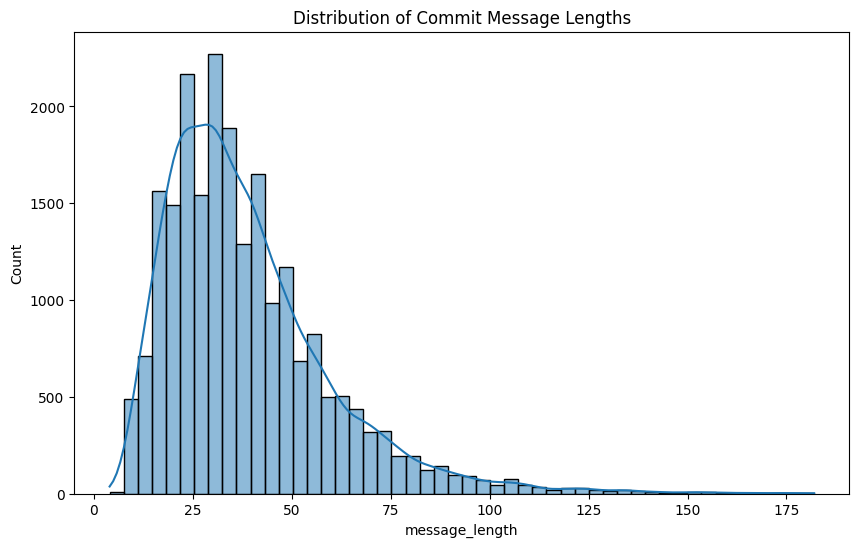

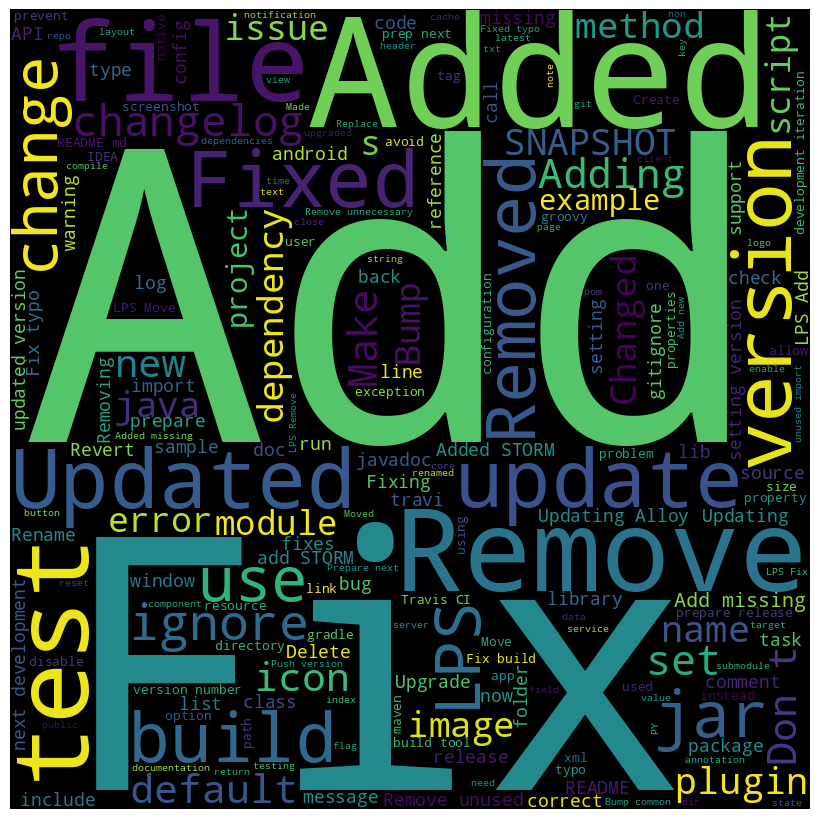

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#message length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['message_length'], bins=50, kde=True)
plt.title('Distribution of Commit Message Lengths')
plt.show()

#frequency of words
wordcloud = WordCloud(width = 600, height = 600, min_font_size = 10).generate(' '.join(df['message']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

The histogram here indicates a roughly normal distribution of commit message lengths with a peak around 25-30 characters, which suggests that most commit messages are relatively short. (makes sense from a practical pov)

and words like "fix", "remove", "update", "add", "new", and "test" stand out in these commit messages

In [32]:
import re
def clean_text(text):
  text = text.lower()  #lowercase
  text = re.sub(r'[^a-zA-Z0-9\s\/\.\-\_]', '', text)  # remving these characters '/', '.', '-', and '_'
  text = text.strip()  #no whitespaces
  return text

df['diff'] = df['diff'].apply(clean_text)
df['message'] = df['message'].apply(clean_text)


In [33]:
#adding start and end tokens to each msg
df['message'] = df['message'].apply(lambda x: '<start> ' + x + ' <end>')

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_diff_length = 100
max_message_length = 20

#tokenize and padding diffs
diff_tokenizer = Tokenizer()
diff_tokenizer.fit_on_texts(df['diff'])
diffs_seq = diff_tokenizer.texts_to_sequences(df['diff'])
diffs_padded = pad_sequences(diffs_seq, maxlen=max_diff_length, padding='post')

#tokenize and padding msgs
msg_tokenizer = Tokenizer(filters='')  # Ensure '<', '>', and ' ' are not filtered out
msg_tokenizer.fit_on_texts(df['message'])
msgs_seq = msg_tokenizer.texts_to_sequences(df['message'])
msgs_padded = pad_sequences(msgs_seq, maxlen=max_message_length, padding='post')

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diffs_padded, msgs_padded, test_size=0.2)


In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

#dimensions
embedding_dim = 100
lstm_units = 64

#encoder
encoder_inputs = Input(shape=(max_diff_length,))
encoder_embedding = Embedding(input_dim=len(diff_tokenizer.word_index)+1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#decoder
decoder_inputs = Input(shape=(max_message_length,))
decoder_embedding = Embedding(input_dim=len(msg_tokenizer.word_index)+1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(msg_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [37]:
#prepping decoder input data- y_train with start token in the beginning
decoder_input_data = np.zeros_like(y_train)
decoder_input_data[:, 1:] = y_train[:,:-1]
decoder_input_data[:, 0] = msg_tokenizer.word_index['<start>']

#training
model.fit([X_train, decoder_input_data], np.expand_dims(y_train, -1), batch_size=64, epochs=10, validation_split=0.2)


Epoch 1/10
222/222 [==============================] - 216s 939ms/step - loss: 4.1959 - accuracy: 0.5772 - val_loss: 2.6209 - val_accuracy: 0.6224
Epoch 2/10
222/222 [==============================] - 201s 900ms/step - loss: 2.4564 - accuracy: 0.6417 - val_loss: 2.3443 - val_accuracy: 0.6724
Epoch 3/10
222/222 [==============================] - 212s 956ms/step - loss: 2.2790 - accuracy: 0.6687 - val_loss: 2.2547 - val_accuracy: 0.6775
Epoch 4/10
222/222 [==============================] - 218s 984ms/step - loss: 2.1934 - accuracy: 0.6771 - val_loss: 2.2064 - val_accuracy: 0.6860
Epoch 5/10
222/222 [==============================] - 219s 986ms/step - loss: 2.1342 - accuracy: 0.6874 - val_loss: 2.1734 - val_accuracy: 0.6940
Epoch 6/10
222/222 [==============================] - 211s 950ms/step - loss: 2.0851 - accuracy: 0.6946 - val_loss: 2.1437 - val_accuracy: 0.6969
Epoch 7/10
222/222 [==============================] - 215s 972ms/step - loss: 2.0415 - accuracy: 0.6994 - val_loss: 2.1217 -

In [38]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
  curr_state = encoder_model.predict(input_seq)

  #generate empty target sequence of length 1 with only the start token
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = msg_tokenizer.word_index['<start>']

  stop_cond = False
  decoded_sent = ''

  while not stop_cond:
    output_tokens, h, c = decoder_model.predict([target_seq] + curr_state)

    #get a token and add the corresponding character to the decoded sentence
    tok_ind = np.argmax(output_tokens[0, -1, :])
    sampled_char = msg_tokenizer.index_word[tok_ind]
    decoded_sent= decoded_sent+ ' ' + sampled_char

    # exiting if: either hit max length or find the stop token
    if (sampled_char == '<end>' or len(decoded_sent) > max_message_length):
      stop_cond = True

    #updating the target sequence which was fof length 1
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tok_ind

    #updating the state
    curr_state = [h, c]

  return decoded_sent


In [39]:
with open('/content/drive/MyDrive/nlp/proj/nngen/data/cleaned.test.diff', 'r') as file:
  test_diffs = file.read().splitlines()

selected_diff = test_diffs[0]


processed_diff = clean_text(selected_diff)
tokenized_diff = diff_tokenizer.texts_to_sequences([processed_diff])
padded_diff = pad_sequences(tokenized_diff, maxlen=max_diff_length, padding='post')

# generating the commit message
generated_message = decode_sequence(padded_diff)
print(generated_message)


1/1 [==============================] - 0s 25ms/step
 <start> add storm - changelog


In [27]:
print(X_train.dtype, X_train.shape)
print(y_train.dtype, y_train.shape)

int32 (17689, 100)
object (17689,)
